# Tutorial: Getting the Percent Distribution of Benthic and Geomorphic Classes Given an EEZ

### Purpose
In this tutorial, we'll walk through how to get the percent distribution of benthic and geomorphic classes within the bounds of an Exclusive Economic Zone (EEZ). The percent distribution is based off of the Allen Coral Atlas (ACA) and the EEZ is based off of the Marine Regions web map services layer. This is a starting guide that can serve as a launchpad for further analyses such as comparing the percent distribution of multiple countries and integration of other datasets for analysis.


### Setup
We recommend using a Conda environment with the packages listed below. Instructions to add a Conda environment to a jupyter notebook can be found [here](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084), and Conda documentation can be found [here](https://docs.conda.io/en/latest/).
 
 ### Contents
 
 1. Creating a Dictionary of Countries/Areas and Their Associated Marine Regions ID (MRGID)

 2. Retrieving Benthic and Geomorphic Layers for a Given EEZ

 3. Reproject the Layers to an Equal Area Projection
 
 4. Calculate Percent Distribution for the Benthic and Geomorphic Classes
 
 5. Visualization: Reproducing Donut Charts from the Web Platform
 
 6. Comparison between Tonga and Jamaica
 

### Considerations

- Currently, the Equal Area projection used in this tutorial is Eckert IV. Further work and research is being conducted to find the optimal projection that accurately reflects the total area for an EEZ.
- Error handling has not been implemented for clarity's sake
- Unit testing has not been implemented but is advised when doing these analyses
- For regions such as Fiji, it is advised to change projections to a Pacific centered projection


### Packages to Import
- Note: while no explicit calls are made, the `rtree` package is a required dependency for geopandas spatial joins

In [2]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import rtree
import requests

from osgeo import ogr

from owslib.wfs import WebFeatureService
from owslib.wms import WebMapService

ModuleNotFoundError: No module named 'matplotlib'

# 1. Creating a Dictionary of Territories and Their Associated Marine Regions ID (MRGID)

First, we'll create a dictionary with the keys being all the areas within the ACA and the values being the associated Marine Regions ID. We'll need the Marine Regions ID in the second section in order to obtain the EEZ of a specific country/area. To do so, we'll grab the Marine Regions EEZ map and restrict the output with a bounding box that is representative of the ACA area.

Note that this request can take up to 3 minutes.

In [2]:
wfs = WebFeatureService(url='https://geo.vliz.be/geoserver/MarineRegions/wfs', version='1.1.0')
response = wfs.getfeature(typename='MarineRegions:eez', 
                          bbox=(-180,-23.5,180,20), 
                          srsname='urn:x-ogc:def:crs:EPSG:4326', 
                          outputFormat='application/json')
eez_data = json.load(response)

Here, we create the dictionary and ensure that disputed and/or shared territories are included with the following filtering parameters.

In [3]:
mrgid_dict = {}
for country in eez_data['features']:
    if country['properties']['pol_type'] == '200NM':
        mrgid_dict[country['properties']['territory1']] = country['properties']['mrgid']
    else:
        mrgid_dict[country['properties']['geoname']] = country['properties']['mrgid']

Now that we have successfully created a dictionary of countries/areas with their associated MRGID, we can take a look at the first 10 entries.

In [4]:
{eez: mrgid_dict[eez] for eez in list(mrgid_dict)[:10]}

{'Chagos Archipelago': 62589,
 'Joint regime area Colombia / Dominican Republic': 48970,
 'Overlapping claim: Venezuela / Colombia / Dominican Republic': 48971,
 'Joint regime area Honduras / Cayman Islands': 48972,
 'Venezuela': 8433,
 'Honduras': 8427,
 'Johnston Atoll': 8452,
 'Colombia': 8426,
 'Yemen': 8353,
 'Christmas Island': 8309}

In total, we have 171 entries.

In [5]:
len(mrgid_dict)

171

# 2. Retrieving Benthic and Geomorphic Layers for a Given EEZ

With our dictionary completed, we can now go through the process of obtaining the benthic and geomorphic layers for a specific area of interest. There are four steps to this:

1. Getting the EEZ area based off of a MRGID
2. Making a bounding box from said EEZ area
3. Obtaining the layers from the ACA using the bounding box
4. Getting the intersection between the ACA and the Marine Regions EEZ area


Here is the overview of the helper functions to achieve these four steps:

- `get_eez_map(country_mrgid)`: Gets the EEZ geojson from the Marine Regions GeoServer
- `make_bounding_box(geojson)`: Transforms a geojson to a bounding box
- `get_aca_layer(layer, bounding_box)`: Given a bounding box, a request is made and downloads either the benthic and geomorphic layers from the Allen Coral Atlas
- `eez_intersection(aca_layer,eez)`: Get the intersection between the Allen Coral Atlas layers and the EEZ geojson from Marine Regions

Note: The external inquiry made in the `get_eez_map` method can take more than a minute.

In [6]:
def get_eez_map(country_mrgid):
    '''Given a country mrgid(Marine region country code), returns a geojson of a country\'s EEZ'''
    url = 'https://geo.vliz.be/geoserver/MarineRegions/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=eez&cql_filter=mrgid=' + str(country_mrgid) + '&outputformat=application/json'
    response = requests.get(url)
    eez = response.json()
    return eez

The `make_bounding_box` helper function grabs the first feature and protects if from wrapping at the antimeridian.

In [7]:
def make_bounding_box(geojson):
    '''From a geojson, creates a bounding box which is a list of 4 coordinates'''
    geom_text = json.dumps(geojson["features"][0]["geometry"])
    geom = ogr.CreateGeometryFromJson(geom_text)
    env = geom.GetEnvelope()

    MAX_LONG = 180.0
    MIN_LONG = -180.0
    MAX_LAT = 90.0
    MIN_LAT = -90.0

    return (max(min(MAX_LONG, env[0]), MIN_LONG),
            max(min(MAX_LAT, env[2]), MIN_LAT),
            max(min(MAX_LONG, env[1]), MIN_LONG),
            max(min(MAX_LAT, env[3]), MIN_LAT))

In [1]:
def get_aca_layer(layer, bounding_box):
    '''Gets either geomorphic or benthic layer in geojson from the ACA'''
    # layer options: ['reef_polygons_benthic_expanded'] or ['reef_polygons_geomorphic_expanded']
    wms = WebMapService('https://allencoralatlas.org/geoserver/coral-atlas/wms', version='1.3.0')
    country_aca_layer = wms.getmap(layers=layer, 
                                   srs='EPSG:4326', 
                                   bbox=bounding_box, 
                                   size=(1000,1000),
                                   format='application/json;type=geojson')
    try:
        country_aca_layer_geojson = json.load(country_aca_layer)
        return country_aca_layer_geojson
    except ValueError:
        if country_aca_layer._response.status_code == 429:
            print('Too many requests have been made in a given amount of time, please wait another minute to send another request.')
        else:
            print('Error acquiring layer, response code: ' + country_aca_layer._response.status_code)         

After obtaining the intersection, the layers are now in GeoDataFrame for ease of calculating percent distribution in the next steps.

In [9]:
def eez_intersection(aca_layer, eez):
    '''After getting a benthic/geomorphic layer, get EEZ region in the form of a geodataframe'''
    aca_layer = gpd.GeoDataFrame.from_features(aca_layer)
    eez = gpd.GeoDataFrame.from_features(eez)
    eez_aca_combined = gpd.sjoin(aca_layer, eez)

    return eez_aca_combined

## Example: Obtaining the Benthic and Geomorphic Layers of Tonga
Let's take what we've learned so far to retrieve both the benthic and geomorphic layers of Tonga. We'll first use our MRGID dictionary created in the beginning of the tutorial, `mrgid_dict`, to find Tonga's MRGID.

In [10]:
mrgid_dict['Tonga']

8448

We'll now use this ID to get the bounding box of Tonga's EEZ.

In [11]:
tonga = get_eez_map(mrgid_dict['Tonga'])
tongabbox = make_bounding_box(tonga)

Here, we can take a look at the bounding box coordinates.

In [12]:
tongabbox

(-179.08824883, -25.69605746, -171.30527778, -14.15464022)

We'll now take our `tongabbox` and obtain the benthic and geomorphic layers using our previously defined `get_aca_layer` function we defined earlier. Currently, to request the benthic layer, ['benthic_data_verbose'], is used and to request the geomorphic layer, ['geomorphic_data_verbose'], is used.

Note: To prevent overloading the GeoServer, it is advised to wait a minute between each request.

In [20]:
benthic_tonga = get_aca_layer(['benthic_data_verbose'], tongabbox)

In [22]:
geomorphic_tonga = get_aca_layer(['geomorphic_data_verbose'], tongabbox)

We'll now obtain the intersection between the ACA layers and the Marine Regions EEZ using our defined `eez_intersection` function. The intersection will return a GeoDataFrame which will make data analysis easier.

In [26]:
benthic_tonga_eez = eez_intersection(benthic_tonga, tonga)

In [25]:
geomorphic_tonga_eez = eez_intersection(geomorphic_tonga, tonga)

Taking a closer look at what we have, we see that each row of the geodataframe is a polygon that is one of the benthic/geomorphic subtypes.

In [28]:
benthic_tonga_eez

,geometry,area_sqkm,class_name,index_right,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,...,area_km2,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3
8,"POLYGON ((-175.29656 -21.06398, -175.29656 -21...",0.001764,Rock,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
9,"POLYGON ((-175.32874 -21.06503, -175.32874 -21...",0.000009,Seagrass,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
178,"POLYGON ((-175.33087 -21.06634, -175.33087 -21...",0.000085,Coral/Algae,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
179,"MULTIPOLYGON (((-175.32653 -21.06046, -175.326...",0.047938,Rock,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
182,"POLYGON ((-175.29289 -21.05943, -175.29140 -21...",0.094319,Rubble,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16881,"POLYGON ((-173.75286 -15.85832, -173.74999 -15...",0.065973,Coral/Algae,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16882,"POLYGON ((-173.77878 -15.94272, -173.77783 -15...",0.023450,Sand,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16883,"POLYGON ((-173.78007 -15.93441, -173.77788 -15...",0.026029,Sand,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16886,"MULTIPOLYGON (((-173.77155 -15.94213, -173.766...",0.084209,Rock,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None


In [29]:
geomorphic_tonga_eez

,geometry,area_sqkm,class_name,index_right,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,...,area_km2,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3
117,"POLYGON ((-175.60230 -15.60937, -175.60230 -15...",0.000192,Reef Slope,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
118,"POLYGON ((-175.65512 -15.57420, -175.65512 -15...",0.000096,Plateau,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
119,"POLYGON ((-175.61559 -15.57420, -175.61559 -15...",0.000096,Reef Slope,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
120,"POLYGON ((-175.69857 -15.63331, -175.69857 -15...",0.000048,Reef Slope,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
121,"POLYGON ((-175.60775 -15.71162, -175.60775 -15...",0.000024,Reef Slope,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16241,"MULTIPOLYGON (((-173.75277 -15.83739, -173.749...",0.641733,Terrestrial Reef Flat,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16242,"POLYGON ((-173.76545 -15.96432, -173.76472 -15...",0.045133,Terrestrial Reef Flat,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16243,"POLYGON ((-173.77191 -15.94191, -173.76629 -15...",0.031379,Terrestrial Reef Flat,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None
16246,"POLYGON ((-173.77235 -15.94326, -173.77173 -15...",0.035124,Inner Reef Flat,0,8448,Tongan Exclusive Economic Zone,8674,200NM,8674,Tonga,...,666052,TON,None,None,776,None,None,776,None,None


# 3. Reprojection of Benthic and Geomorphic Layers

We now have the benthic and geomorphic layers for Tonga, but before we can do any further analyses, we have to ensure that we have the right map projection. More information on choosing the correct map projections can be found [here](https://learn.arcgis.com/en/projects/choose-the-right-projection/). To get an accurate estimate of percent distribution, it is imperative to reproject the layers to an equal area projection. The ACA has a default projection of EPSG:4326. Within our `reproject` function below, we've chosen the Mollweide projection (ESRI:54009) which has a suitable extent for the world.

A quick overview of the `reproject` function is to set the original CRS before projecting, which in this case for the ACA is EPSG:4326, and then we reproject to our desired map projection and simultaneously calculate the area for each feature in km<sup>2</sup>. This new area is also added as a new column in our geodataframe.

In [62]:
def reproject(eez_geodataframe, projection_identifier):
    '''Reprojects a geodataframe to the user provided projection'''
    # e.g. Mollweide would be 'ESRI:54009'
    # set original CRS before reprojecting, in this case, the data obtained 
    # from the Allen Coral Atlas is in the EPSG:4326 format
    eez_geodataframe.crs = 'EPSG:4326'
    
    # adds a column, 'reprojected_area' that converts the 
    # current area to user provided projection
    eez_geodataframe['reprojected_area'] = eez_geodataframe['geometry'].to_crs(projection_identifier).map(lambda p: p.area / 10**6)
    
    return eez_geodataframe

In [31]:
reprojected_tonga_benthic = reproject(benthic_tonga_eez, 'ESRI:54009')

In [32]:
reprojected_tonga_geomorphic = reproject(geomorphic_tonga_eez, 'ESRI:54009')

# 4. Calculating the Percent Distribution of Benthic and Geomorphic Classes

With our reprojected benthic and geomorphic layers, we can now calculate the percent distribution by benthic/geomorphic subtypes.

In the `calculate_percent_distribution` function, we first calculate the total area for the classes and then calculate the subtotals in a new geodataframe.

In [38]:
def calculate_percent_distribution(eez_geodataframe): 
    # generates a new dataframe containing the subtotal 
    # of the area of benthic/geomorphic classes 
    eez_geodataframe_subtotals = eez_geodataframe.groupby('class_name')['reprojected_area'].sum().to_frame()
    
    # adds a new column that has the percent distribution
    # for each class
    eez_geodataframe_subtotals['percent_distribution'] = eez_geodataframe_subtotals['reprojected_area'].map(lambda p: p/sum(eez_geodataframe_subtotals['reprojected_area']) * 100)

    return eez_geodataframe_subtotals

### Tonga Benthic Class Percent Distribution
Let's now calculate the benthic percent distribution for Tonga.

In [39]:
benthic_tonga = calculate_percent_distribution(reprojected_tonga_benthic)

Now, if we take a look at our newly generated dataframe, we can see the benthic composition of the EEZ of Tonga.

In [41]:
benthic_tonga

,reprojected_area,percent_distribution
class_name,,
Coral/Algae,490.601908,54.055603
Microalgal Mats,63.815953,7.031383
Rock,109.304519,12.043414
Rubble,101.944018,11.232417
Sand,113.354807,12.489683
Seagrass,28.566311,3.147499


### Tonga Geomorphic Class Percent Distribution
And we can do the same for the geomorphic class.

In [42]:
geomorphic_tonga = calculate_percent_distribution(reprojected_tonga_geomorphic)

In [44]:
geomorphic_tonga

,reprojected_area,percent_distribution
class_name,,
Back Reef Slope,95.547478,7.786200
Deep Lagoon,142.132516,11.582432
Inner Reef Flat,117.762508,9.596511
Outer Reef Flat,138.737408,11.305764
Plateau,107.089075,8.726729
Reef Crest,39.778539,3.241568
Reef Slope,311.149062,25.355654
Shallow Lagoon,87.278635,7.112369
Sheltered Reef Slope,67.412934,5.493505


# 5. Visualization: Reproducing Donut Charts from the Web Platform
Using the `matplotlib` library and this [tutorial](https://towardsdatascience.com/donut-plot-with-matplotlib-python-be3451f22704), here's how we can reproduce the graph from the web platform. In addition, the graphs can be easily customized as needed.

### Tonga Benthic Class Distribution

In [115]:
def plot_benthic(benthic_layer_geodataframe, eez_name):
    # Donut chart
    labels = list(benthic_layer_geodataframe.index)
    color_dict = {'Coral/Algae': '#ff6157',
                  'Microalgal Mats': '#9bcc4f',
                  'Rock': '#b19c3a',
                  'Rubble': '#e0d05e',
                  'Sand': '#ffffbe',
                  'Seagrass': '#668438'}
    colors = []
    for class_name in list(benthic_layer_geodataframe.index):
        if color_dict[class_name]:
            colors.append(color_dict[class_name])
            
    sizes = list(benthic_layer_geodataframe['percent_distribution'])

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

    # Draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title(eez_name + ' Benthic Class Distribution', pad=20)
    plt.show()

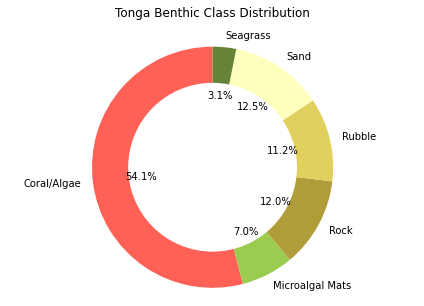

In [116]:
plot_benthic(benthic_tonga, 'Tonga')

### Tonga Geomorphic Class Distribution

In [127]:
def plot_geomorphic(geomorphic_layer_geodataframe, eez_name):
    # Donut chart
    labels = list(geomorphic_layer_geodataframe.index)
    colors = []
    color_dict = {'Back Reef Slope': '#befbff',
                 'Deep Lagoon': '#2ca2f9',
                 'Inner Reef Flat': '#c5a7cb',
                 'Outer Reef Flat': '#9a7fa4',
                 'Plateau': '#cd6812',
                 'Reef Crest': '#614272',
                 'Reef Slope': '#288471',
                 'Shallow Lagoon': '#77d0fc',
                 'Sheltered Reef Slope': '#10bda6',
                 'Terrestrial Reef Flat': '#fbdefb'}
    for class_name in list(geomorphic_layer_geodataframe.index):
        if color_dict[class_name]:
            colors.append(color_dict[class_name])
        
    sizes = list(geomorphic_layer_geodataframe['percent_distribution'])
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

    # Draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title(eez_name + ' Geomorphic Class Distribution', pad=20)
    plt.show()

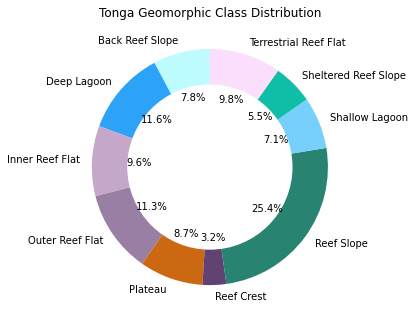

In [128]:
plot_geomorphic(geomorphic_tonga, 'Tonga')

# 6. Comparison between Tonga and Jamaica
We can also easily see the diversity between Tonga and Jamaica. Briefly, we'll go through the steps as we did with Tonga for Jamaica.

In [49]:
mrgid_dict['Jamaica']

8459

In [50]:
jamaica = get_eez_map(mrgid_dict['Jamaica'])
jamaica_bbox = make_bounding_box(jamaica)

In [51]:
jamaica_bbox

(-80.83305556, 14.08333333, -74.00943069, 19.35780663)

In [55]:
jamaica_geomorphic = get_aca_layer(['geomorphic_data_verbose'], jamaica_bbox)

In [53]:
jamaica_benthic = get_aca_layer(['benthic_data_verbose'], jamaica_bbox)

In [57]:
jamaica_geomorphic_eez = eez_intersection(jamaica_geomorphic, jamaica)

In [59]:
jamaica_benthic_eez = eez_intersection(jamaica_benthic, jamaica)

In [63]:
reprojected_jamaica_benthic = reproject(jamaica_benthic_eez, 'ESRI:54012')

In [64]:
reprojected_jamaica_geomorphic = reproject(jamaica_geomorphic_eez, 'ESRI:54012')

In [65]:
benthic_jamaica = calculate_percent_distribution(reprojected_jamaica_benthic)

In [67]:
geomorphic_jamaica = calculate_percent_distribution(reprojected_jamaica_geomorphic)

Let's first take a look at the benthic distributions:

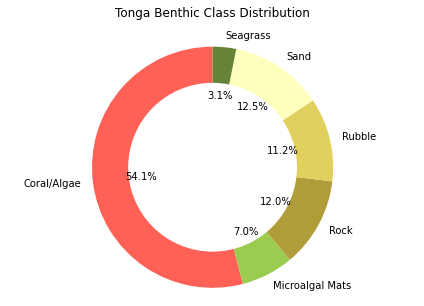

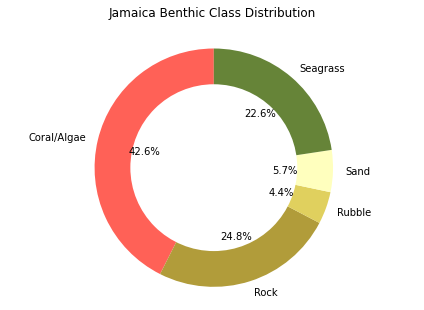

In [129]:
plot_benthic(benthic_tonga, 'Tonga')
plot_benthic(benthic_jamaica, 'Jamaica')

With the charts displayed, we can appreciate the diversity between the corals in the Caribbean and South Pacific Ocean. Characteristic of the Caribbean environment, there is a high density of seagrass.
Let's also take a look at the geomorphic distribution:

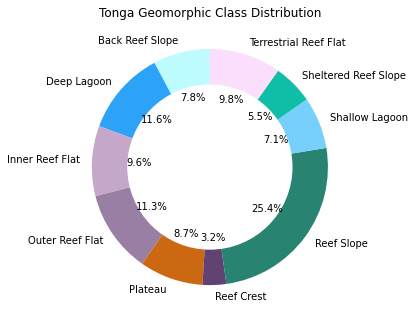

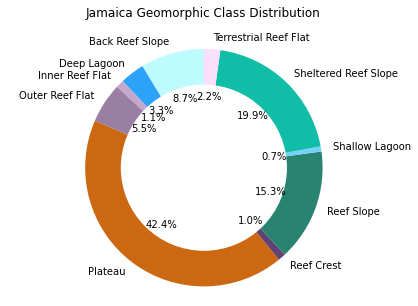

In [130]:
plot_geomorphic(geomorphic_tonga, 'Tonga')
plot_geomorphic(geomorphic_jamaica, 'Jamaica')